# Data QC for the Country of Birth

Yosuke Tanigawa (3/28/2020)

In [1]:
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(data.table))


In [2]:
d <- '/oak/stanford/groups/mrivas/ukbb24983/phenotypedata/extras/country_of_birth/misc/'

# input
f <- file.path(d, 'ukb2005693_ukb37855.fields1647_20115.tsv.zst')
coding89f     <- file.path(d, 'coding89.tsv')
coding100420f <- file.path(d, 'coding100420.tsv')

remove_f <- '/oak/stanford/groups/mrivas/ukbb24983/sqc/w24983_20200204.csv'
master_sqc_f <- '/oak/stanford/groups/mrivas/ukbb24983/sqc/population_stratification_w24983_20200313/ukb24983_master_sqc.20200313.phe'


In [3]:
# output
out_tsv_f <- file.path(d, 'ukb2005693_ukb37855.country_of_birth.tsv')
out_coding_tsv_f <- file.path(d, 'ukb2005693_ukb37855.country_of_birth.coding.tsv')


In [4]:
coding_df <- 
bind_rows(
    fread(coding89f) %>%
    mutate(field  = 20115),

    fread(coding100420f) %>%
    mutate(field = 1647)
) %>%
rename('coding'='#coding') %>%
left_join(
    fread(coding89f) %>%
    rename('coding'='#coding')%>%
    select(coding, meaning) %>%
    rename('parent_meaning'='meaning'),
    by=c('parent_id'='coding')
)

In [5]:
coding_df %>%
filter(coding < 0)

coding,meaning,node_id,parent_id,selectable,field,parent_meaning
<int>,<chr>,<int>,<int>,<chr>,<dbl>,<chr>
-3,Prefer not to answer,NA,NA,NA,1647,NA
-1,Do not know,NA,NA,NA,1647,NA


In [6]:
remove_l <- fread(remove_f, head=F) %>% mutate(V1 = as.character(V1)) %>%pull(V1)

In [7]:
sqc_df <- master_sqc_f %>% fread(
    select=c('FID', 'IID', 'putative_sex_chromosome_aneuploidy', 'het_missing_outliers', 'pass_filter'),
    colClasses=c('FID'='character', 'IID'='character')
)


In [8]:
sqc_df %>%
count(putative_sex_chromosome_aneuploidy, het_missing_outliers)

putative_sex_chromosome_aneuploidy,het_missing_outliers,n
<int>,<int>,<int>
0,0,486757
0,1,968
1,0,652


In [9]:
df <- fread(cmd=paste('zstdcat', f)) %>%
rename('IID' = '#IID') %>%
mutate(IID = as.character(IID)) %>%
left_join(
    coding_df, 
    by=c('val'='coding', 'field')
) %>%
left_join(
    sqc_df %>%
    select(IID, putative_sex_chromosome_aneuploidy, het_missing_outliers), 
    by='IID'
) %>%
filter(
    !((field == 1647) & val %in% c(-3, -1)),
    !(IID %in% remove_l),
    putative_sex_chromosome_aneuploidy == 0,
    het_missing_outliers == 0
)


## explorer the basic characteristics

In [10]:
df %>% count(time, array, tab_file)

time,array,tab_file,n
<int>,<int>,<chr>,<int>
0,0,ukb37855.tab,524267
1,0,ukb37855.tab,20161
2,0,ukb37855.tab,11386


## how many different kinds of answers?

In [11]:
df %>% nrow()

[1] 555814

In [12]:
df %>% select(-time, -array) %>% unique() %>% nrow()


[1] 524313

In [13]:
df %>% 
select(IID, val) %>%
unique() %>%
count(IID) %>%
rename('n_distinct_answers_per_individual' = 'n') %>%
count(n_distinct_answers_per_individual)


n_distinct_answers_per_individual,n
<int>,<int>
1,447342
2,38460
3,17


In [14]:
df %>% 
group_by(field) %>%
select(field, IID, val) %>%
unique() %>%
count(field, IID) %>%
rename('n_distinct_answers_per_individual' = 'n') %>%
count(n_distinct_answers_per_individual)


field,n_distinct_answers_per_individual,n
<dbl>,<int>,<int>
1647,1,485275
1647,2,36
20115,1,38966


In [15]:
intersect(
    df %>% filter(field == 1647) %>% pull(IID),
    df %>% filter(field == 20115) %>% pull(IID)
) %>% 
length()


[1] 38458

In [16]:
df %>%
filter(
    field == 1647,
    IID %in% intersect(
        df %>% filter(field == 1647) %>% pull(IID),
        df %>% filter(field == 20115) %>% pull(IID)
    )
) %>%
select(IID, val, field) %>%
unique() %>%
count(val, field) %>%
left_join(
    coding_df, by=c('field', 'val'='coding')
)

val,field,n,meaning,node_id,parent_id,selectable,parent_meaning
<int>,<dbl>,<int>,<chr>,<int>,<int>,<chr>,<chr>
1,1647,219,England,NA,NA,NA,NA
2,1647,13,Wales,NA,NA,NA,NA
3,1647,32,Scotland,NA,NA,NA,NA
4,1647,4,Northern Ireland,NA,NA,NA,NA
5,1647,2,Republic of Ireland,NA,NA,NA,NA
6,1647,38205,Elsewhere,NA,NA,NA,NA


we should remove `Elsewhere`

In [17]:
df %>% 
filter(
    !((field == 1647) & (val == 6))
) %>%
select(IID, val) %>%
unique() %>%
count(IID) %>%
rename('n_distinct_answers_per_individual' = 'n') %>%
count(n_distinct_answers_per_individual)


n_distinct_answers_per_individual,n
<int>,<int>
1,485470
2,286


290 individuals have multiple answers. Let's remove them for now.

In [18]:
non_dup_IIDs <- df %>% 
filter(
    !((field == 1647) & (val == 6)),
) %>%
select(IID, val) %>%
unique() %>%
count(IID) %>%
filter(n == 1) %>%
pull(IID)

In [19]:
df %>% 
filter(
    !((field == 1647) & (val == 6)),
    IID %in% non_dup_IIDs
) %>%
select(IID, val) %>%
unique() %>%
count(IID) %>%
rename('n_distinct_answers_per_individual' = 'n') %>%
count(n_distinct_answers_per_individual)


n_distinct_answers_per_individual,n
<int>,<int>
1,485470


This confirms we have unique answer for 485,470 individuals

## Top level counts

In [20]:
df %>% 
filter(
    !((field == 1647) & (val == 6)),
    IID %in% non_dup_IIDs
) %>%
mutate(
    top_level = if_else(is.na(parent_id), meaning, parent_meaning)
) %>%
count(field, top_level) %>%
arrange(-n)

field,top_level,n
<dbl>,<chr>,<int>
1647,England,406905
1647,Scotland,39794
1647,Wales,22100
20115,Africa,12199
20115,Asia,11360
20115,Europe,9544
1647,Republic of Ireland,5006
1647,Northern Ireland,3178
20115,North America,2610


## Count the number of individuals for each country

In [21]:
count_df <- df %>% 
filter(
    !((field == 1647) & (val == 6)),
    IID %in% non_dup_IIDs
) %>%
left_join(sqc_df, by='IID') %>%
replace_na(list(pass_filter=F))%>%
count(field, val, meaning, parent_id, parent_meaning, pass_filter) %>%
mutate(pass_filter = if_else(pass_filter, 'unrelated_n', 'total_n')) %>%
spread(pass_filter, n, fill=0) %>%
mutate(total_n = unrelated_n + total_n)


In [22]:
count_df %>%
arrange(-total_n) %>%
select(-unrelated_n) %>%
head(20)

field,val,meaning,parent_id,parent_meaning,total_n
<dbl>,<int>,<chr>,<int>,<chr>,<dbl>
1647,1,England,NA,NA,406905
1647,3,Scotland,NA,NA,39794
1647,2,Wales,NA,NA,22100
1647,5,Republic of Ireland,NA,NA,5006
20115,212,India,200,Asia,3979
1647,4,Northern Ireland,NA,NA,3178
20115,109,Caribbean,100,Africa,2669
20115,320,Germany,300,Europe,2126
20115,124,Kenya,100,Africa,1667


In [23]:
count_df %>%
arrange(total_n) %>%
select(-unrelated_n) %>%
head(20)

field,val,meaning,parent_id,parent_meaning,total_n
<dbl>,<int>,<chr>,<int>,<chr>,<dbl>
20115,103,Benin,100,Africa,1
20115,105,Burkina,100,Africa,1
20115,111,Comoros,100,Africa,1
20115,122,Guinea-Bissau,100,Africa,1
20115,130,Mauritania,100,Africa,1
20115,210,Emirates,200,Asia,1
20115,227,Maldives,200,Asia,1
20115,231,Oman,200,Asia,1
20115,234,Pattaya,200,Asia,1


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


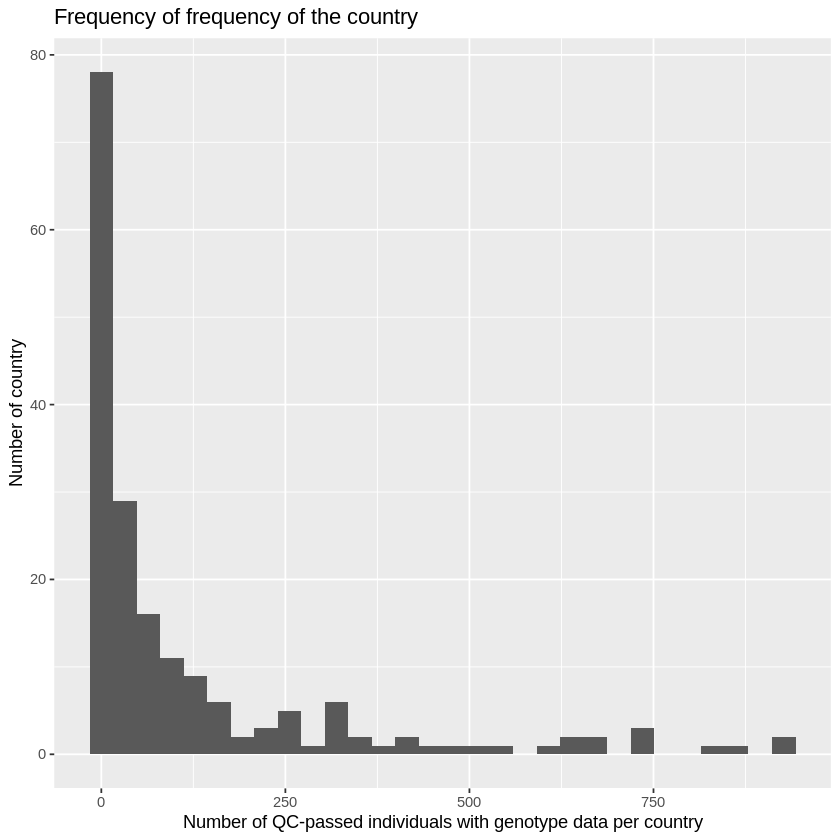

In [24]:
count_df %>%
filter(total_n < 1000) %>%
ggplot(aes(x=total_n)) +
geom_histogram() + 
labs(
    title = 'Frequency of frequency of the country',
    x = 'Number of QC-passed individuals with genotype data per country',
    y = 'Number of country'
)

## aggregate and reformat

In [25]:
N_agg <- 30

We keep countries with at least 30 individuals with genotype data

In [26]:
agg_df <- df %>%
filter(
    !((field == 1647) & (val == 6)),
    IID %in% non_dup_IIDs
) %>%
mutate(
    aggregate = (
        (field == 20115) &
        (val %in% (count_df %>% filter(field == 20115, total_n < N_agg) %>% pull(val)))
    )
) %>%
mutate(
    field_val       = paste(field, val, sep='_'),
    field_parent_id = paste(field, parent_id, sep='_'),
    country_of_birth_id  = if_else(aggregate, field_parent_id, field_val),
    country_of_birth_txt = if_else(aggregate, parent_meaning,  meaning),
    country_of_birth_top_level_id  = if_else(is.na(parent_id), field_val, field_parent_id),
    country_of_birth_top_level_txt = if_else(is.na(parent_id), meaning,   parent_meaning)
) %>%
rename(
    'country_of_birth_raw_id' = 'field_val',
    'country_of_birth_raw_txt' = 'meaning',
) %>%
mutate(FID = IID) %>%
left_join(sqc_df %>% mutate(sort_order = 1:n()), by=c('FID', 'IID')) %>%
arrange(sort_order) %>%
select(
    FID, IID, pass_filter,
    country_of_birth_id, country_of_birth_txt, 
    country_of_birth_top_level_id, country_of_birth_top_level_txt,
    country_of_birth_raw_id, country_of_birth_raw_txt
)


In [27]:
coding_agg_df <- coding_df %>%
mutate(
    field_val        = paste(field, coding, sep='_'),
    parent_field_val = paste(field, parent_id, sep='_')
) %>%
left_join(    
    count_df %>% 
    select(field, val, unrelated_n, total_n),
    by=c('field', 'coding'='val')
) %>%
replace_na(list('unrelated_n' = 0, 'total_n' = 0)) %>%
arrange(field, coding)%>%
select(field_val, meaning, parent_field_val, parent_meaning, unrelated_n, total_n)


In [28]:
agg_df %>%
rename('#FID' = 'FID') %>%
fwrite(out_tsv_f, sep='\t', na = "NA", quote=F)


In [29]:
coding_agg_df %>%
rename('#field_val' = 'field_val') %>%
fwrite(out_coding_tsv_f, sep='\t', na = "NA", quote=F)
